# シンプルなFC層を用いたモデル

### 方針

・条件付き確率（遷移確率）と尤度の和から次の尤度を求める

### データの生成

・データの用意

In [1]:
import numpy as np

# 依存関係の行列 A (問題の依存関係)
A = np.array([
    [0, 0, 0, 0, 0],  # 問題1は他の問題に依存しない
    [1, 0, 0, 0, 0],  # 問題2は問題1に依存
    [0, 1, 0, 0, 0],  # 問題3は問題1と問題2に依存
    [0, 0, 1, 0, 0],  # 問題4は問題2に依存
    [0, 0, 0, 1, 0]   # 問題5は問題1、問題2、問題3に依存
])


# 次に正解する確率を求める関数
def calculate_transition_probabilities(A, X):
    n = len(X)
    raw_probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 不正解の問題に対して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 不正解の問題のみ計算
            required_problems = A[i, :]  # i番目の問題に必要な依存関係
            
            # 依存関係がすべて0であるかを確認
            if np.all(required_problems == 0):
                raw_probabilities[i] =  10 # 必要なら、この問題の遷移確率を設定
                continue
            
            solved_problems = X * required_problems  # 実際に解けた問題
            
            num_required = np.sum(required_problems)  # 必要な問題の数
            num_solved = np.sum(solved_problems)      # 実際に解けた問題の数
            
            if num_required > 0:
                raw_probabilities[i] = np.exp(3*num_solved / num_required)
    
    # 総和で割って正規化
    total_sum = np.sum(raw_probabilities)  # expの総和
    if total_sum > 0:  # 総和が0でなければ正規化
        probabilities = raw_probabilities / total_sum
    else:
        probabilities = raw_probabilities  # 総和が0ならそのまま
    
    return probabilities

In [2]:
# 生徒の回答状況 X (1が正解、0が不正解)
# 例: 問題1と問題2は正解、問題3と問題4と問題5は不正解
X = np.array([1, 1, 0, 0, 0])

# 遷移確率の計算
probabilities = calculate_transition_probabilities(A, X)

# 結果を表示
print("次に正解する確率:")
for i, prob in enumerate(probabilities):
    print(f"問題{i+1}: {prob:.4f}")

次に正解する確率:
問題1: 0.0000
問題2: 0.0000
問題3: 0.9094
問題4: 0.0453
問題5: 0.0453


In [3]:
# データセットを生成する関数
def generate_dataset(A, initial_X, num_correct_problems, num_data_per_step):
    n = len(initial_X)  # 問題数（今回は5）
    dataset = []
    
    # 正解させたい問題数ごとにデータを生成
    for i in range(num_correct_problems + 1):  # 0から正解問題数 i
        for j in range(num_data_per_step):  # 各ステップごとにデータ数
            X = initial_X.copy()  # 初期状態からスタート
            for k in range(i):  # i問正解させる
                probabilities = calculate_transition_probabilities(A, X)
                
                if np.sum(probabilities) > 0:  # 正規化された確率がある場合
                    # 確率に基づいて次に正解させる問題を選択
                    next_correct_problem = np.random.choice(n, p=probabilities)
                    X[next_correct_problem] = 1  # 選ばれた問題を正解に遷移させる
            
            dataset.append(X.copy())  # データセットに追加
    
    return np.array(dataset)

In [4]:
# データセット生成
num_correct_problems = 5  # 0問から5問まで正解
num_data_per_step = 100     # 各ステップごとに生成するデータ数

# 生徒の回答状況 X (1が正解、0が不正解)
# 初期状態は全て不正解
X_init = np.array([0, 0, 0, 0, 0])

dataset = generate_dataset(A, X_init, num_correct_problems, num_data_per_step)

# 結果を表示
print("生成されたデータセット:")
print(dataset)

生成されたデータセット:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 ...
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [5]:
import itertools
from collections import defaultdict

num_questions = 5

# 問題数5問に対する全ての可能な状態 (2^5 = 32状態)
states = list(itertools.product([0, 1], repeat=num_questions))
print(f"Number of States: {len(states)}\n")

# 各状態（ノード）に生徒を配置する (状態ごとの生徒数をカウント)
state_counts = defaultdict(int)

# 生徒ごとのテスト結果を元に状態に生徒をカウント
for result in dataset:
    state_tuple = tuple(map(int, result))  # np.int64をint型に変換
    state_counts[state_tuple] += 1

# 各状態の生徒数を表示
for state, count in state_counts.items():
    formatted_state = ''.join(map(str, state))  # 状態を'01010'のような形式に変換
    print(f"State [{formatted_state}]: {count} students")


Number of States: 32

State [00000]: 100 students
State [10000]: 72 students
State [00001]: 8 students
State [00100]: 8 students
State [00010]: 7 students
State [01000]: 5 students
State [10010]: 6 students
State [10001]: 8 students
State [11000]: 67 students
State [01100]: 5 students
State [00110]: 5 students
State [10100]: 5 students
State [00011]: 4 students
State [11100]: 67 students
State [10101]: 1 students
State [10110]: 6 students
State [00111]: 3 students
State [10011]: 4 students
State [01101]: 2 students
State [11001]: 7 students
State [01110]: 4 students
State [11010]: 6 students
State [11110]: 71 students
State [10111]: 7 students
State [11011]: 9 students
State [11101]: 12 students
State [01111]: 1 students
State [11111]: 100 students


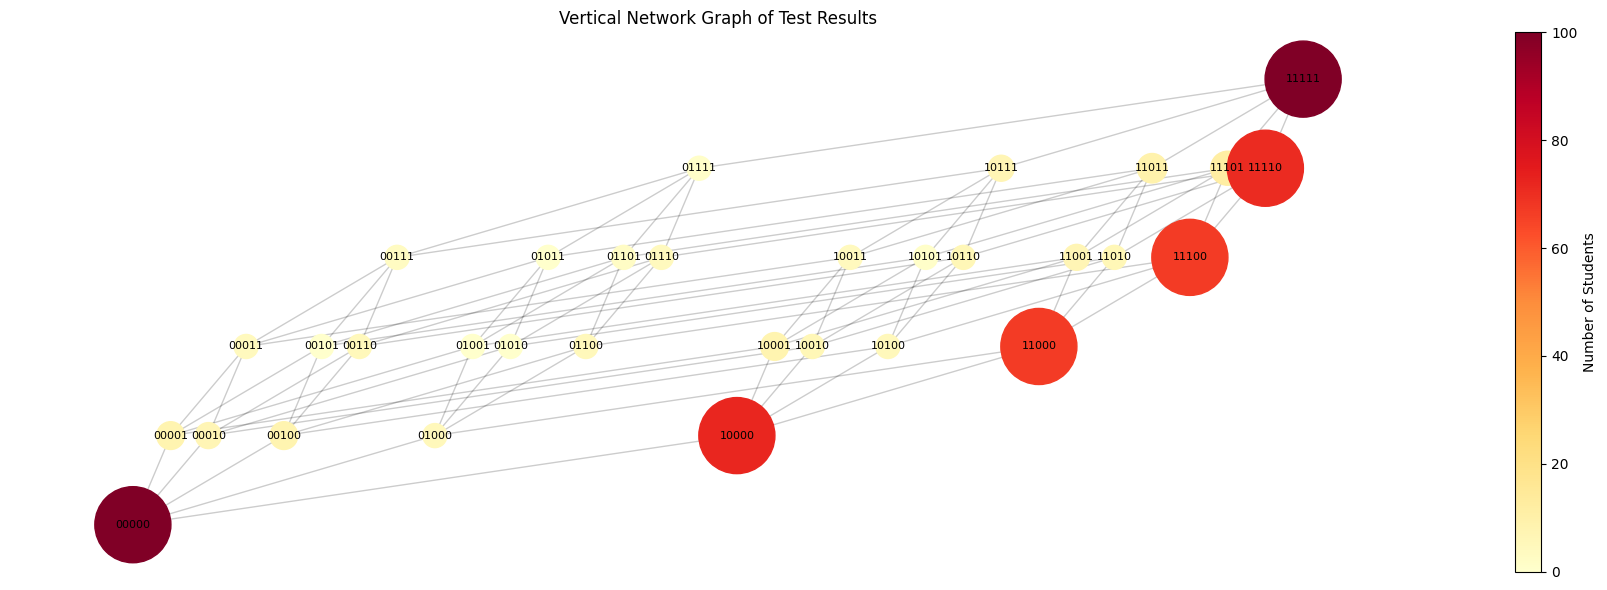

State 00000: 100 students
State 10000: 72 students
State 00001: 8 students
State 00100: 8 students
State 00010: 7 students
State 01000: 5 students
State 10010: 6 students
State 10001: 8 students
State 11000: 67 students
State 01100: 5 students
State 00110: 5 students
State 10100: 5 students
State 00011: 4 students
State 00101: 0 students
State 01001: 0 students
State 01010: 0 students
State 11100: 67 students
State 10101: 1 students
State 10110: 6 students
State 00111: 3 students
State 10011: 4 students
State 01101: 2 students
State 11001: 7 students
State 01110: 4 students
State 11010: 6 students
State 01011: 0 students
State 11110: 71 students
State 10111: 7 students
State 11011: 9 students
State 11101: 12 students
State 01111: 1 students
State 11111: 100 students


In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# グラフの作成
G = nx.Graph()

# ノードの追加
for state in states:
    G.add_node(state, count=state_counts[state])

# エッジの追加
for state in states:
    for i in range(num_questions):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            G.add_edge(state, tuple(next_state))

# カスタムレイアウト関数
def custom_layout(G, num_questions):
    pos = {}
    for state in G.nodes():
        level = sum(state)
        # 各レベルでのノードの数を数える
        level_count = sum(1 for node in G.nodes() if sum(node) == level)
        # このレベルでの現在のノードの位置を計算
        level_position = sum(state[i] * 2**(num_questions-i-1) for i in range(num_questions))
        x = level_position / (2**num_questions - 1)  # x座標を0~1の範囲に正規化
        y = level / num_questions  # y座標を0~1の範囲に正規化
        pos[state] = (x, y)
    return pos

# カスタムレイアウトの適用
pos = custom_layout(G, num_questions)

# プロットの設定
plt.figure(figsize=(18, 6))  # 縦長に変更

# エッジの描画
nx.draw_networkx_edges(G, pos, alpha=0.2)

# ノードの描画
node_sizes = [max(300, min(3000, G.nodes[node]['count'] * 50)) for node in G.nodes()]
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd)

# ノードのラベル描画
nx.draw_networkx_labels(G, pos, {node: ''.join(map(str, node)) for node in G.nodes()}, font_size=8)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

plt.title('Vertical Network Graph of Test Results')
plt.axis('off')
plt.tight_layout()

# グラフの表示
plt.show()

# 各状態の学生数を表示
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")

・遷移確率の計算

In [7]:
# 尤度を保存するための辞書
likelihoods = defaultdict(float)

# 初期状態の尤度は1
initial_state = tuple([0] * num_questions)
likelihoods[initial_state] = 1

# 遷移確率を計算するための準備
transition_probabilities = defaultdict(dict)

# 正解数が少ないものから状態をソート
for current_state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    unresolved_count = num_questions - sum(current_state)  # まだ解けていない問題の数
    
    if unresolved_count == 0:
        continue  # すべて解けている状態ならばスキップ

    # すべての次の状態（遷移先）の生徒数を集計
    total_next_state_students = 0
    next_states = []
    
    # 次に解ける可能性のある未解決の問題を見つける
    for i in range(num_questions):
        if current_state[i] == 0:  # まだ解けていない問題
            # その問題が解けた状態を生成（遷移後の状態）
            next_state = list(current_state)
            next_state[i] = 1
            next_state = tuple(next_state)
            next_states.append(next_state)
            total_next_state_students += state_counts[next_state]

    # 遷移先に誰もいない場合は均等確率
    if total_next_state_students == 0:
        for next_state in next_states:
            transition_prob = 1 / unresolved_count  # 均等に遷移
            likelihoods[next_state] += likelihoods[current_state] * transition_prob
    else:
        # 次の状態に生徒がいる場合、条件付き遷移確率を計算
        for next_state in next_states:
            P_S = state_counts[next_state]  # 遷移先の生徒数
            transition_prob = P_S / total_next_state_students  # 条件付き遷移確率
            likelihoods[next_state] += likelihoods[current_state] * transition_prob

# 結果表示
for state, likelihood in sorted(likelihoods.items(), key=lambda x: sum(x[0])):
    formatted_state = ''.join(map(str, state))
    print(f"State [{formatted_state}] has likelihood: {likelihood:.4f}")

State [00000] has likelihood: 1.0000
State [10000] has likelihood: 0.7200
State [01000] has likelihood: 0.0500
State [00100] has likelihood: 0.0800
State [00010] has likelihood: 0.0700
State [00001] has likelihood: 0.0800
State [11000] has likelihood: 0.6075
State [10100] has likelihood: 0.0685
State [10010] has likelihood: 0.0782
State [10001] has likelihood: 0.1203
State [01001] has likelihood: 0.0000
State [00101] has likelihood: 0.0000
State [00011] has likelihood: 0.0453
State [01100] has likelihood: 0.0301
State [00110] has likelihood: 0.0500
State [01010] has likelihood: 0.0000
State [11010] has likelihood: 0.0749
State [10110] has likelihood: 0.0580
State [10011] has likelihood: 0.0856
State [11001] has likelihood: 0.1233
State [10101] has likelihood: 0.0110
State [11100] has likelihood: 0.5985
State [01110] has likelihood: 0.0170
State [01101] has likelihood: 0.0008
State [00111] has likelihood: 0.0310
State [01011] has likelihood: 0.0000
State [11110] has likelihood: 0.6480
S

・図示

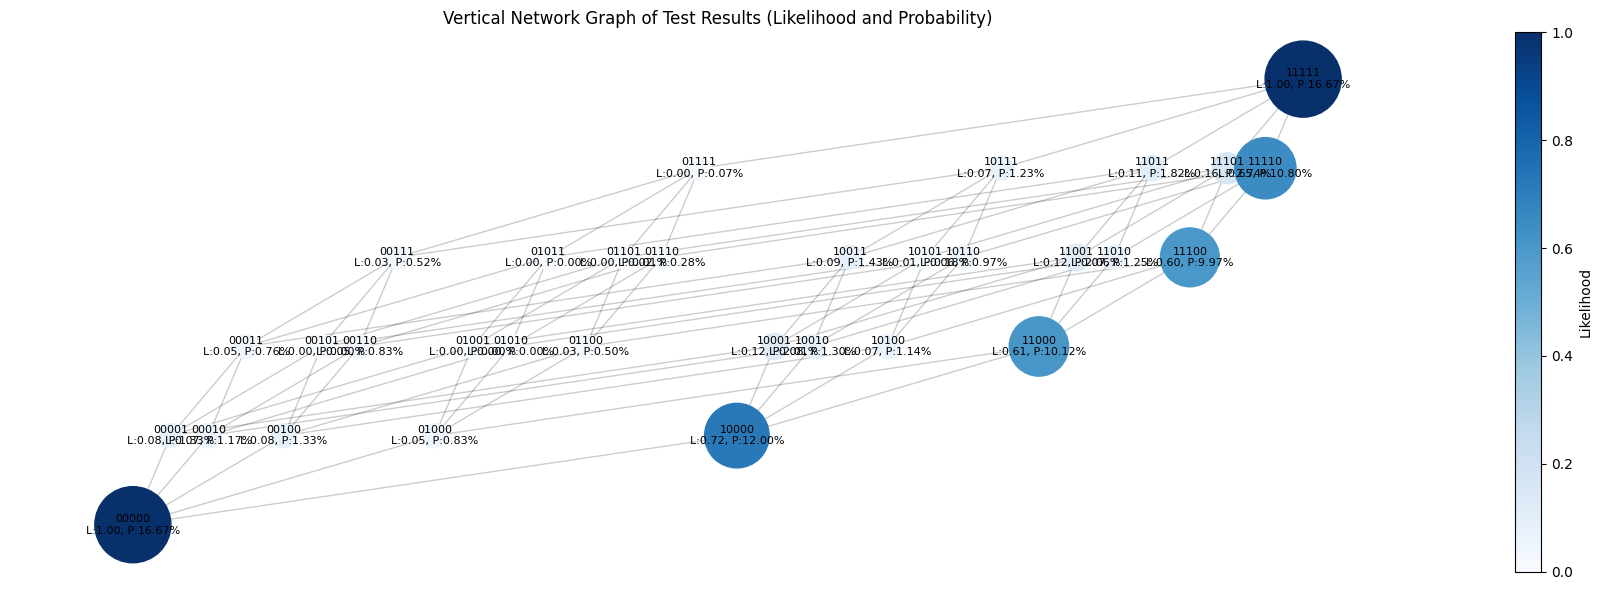

State 00000: Likelihood = 1.0000, Probability = 16.6667%
State 10000: Likelihood = 0.7200, Probability = 12.0000%
State 01000: Likelihood = 0.0500, Probability = 0.8333%
State 00100: Likelihood = 0.0800, Probability = 1.3333%
State 00010: Likelihood = 0.0700, Probability = 1.1667%
State 00001: Likelihood = 0.0800, Probability = 1.3333%
State 11000: Likelihood = 0.6075, Probability = 10.1243%
State 10100: Likelihood = 0.0685, Probability = 1.1421%
State 10010: Likelihood = 0.0782, Probability = 1.3039%
State 10001: Likelihood = 0.1203, Probability = 2.0052%
State 01001: Likelihood = 0.0000, Probability = 0.0000%
State 00101: Likelihood = 0.0000, Probability = 0.0000%
State 00011: Likelihood = 0.0453, Probability = 0.7556%
State 01100: Likelihood = 0.0301, Probability = 0.5023%
State 00110: Likelihood = 0.0500, Probability = 0.8333%
State 01010: Likelihood = 0.0000, Probability = 0.0000%
State 11010: Likelihood = 0.0749, Probability = 1.2483%
State 10110: Likelihood = 0.0580, Probability

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# グラフの作成
G = nx.Graph()

# ノードの追加
for state in states:
    G.add_node(state, likelihood=likelihoods[state])

# エッジの追加
for state in states:
    for i in range(num_questions):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            G.add_edge(state, tuple(next_state))

# カスタムレイアウト関数
def custom_layout(G, num_questions):
    pos = {}
    for state in G.nodes():
        level = sum(state)
        # 各レベルでのノードの数を数える
        level_count = sum(1 for node in G.nodes() if sum(node) == level)
        # このレベルでの現在のノードの位置を計算
        level_position = sum(state[i] * 2**(num_questions-i-1) for i in range(num_questions))
        x = level_position / (2**num_questions - 1)  # x座標を0~1の範囲に正規化
        y = level / num_questions  # y座標を0~1の範囲に正規化
        pos[state] = (x, y)
    return pos

# カスタムレイアウトの適用
pos = custom_layout(G, num_questions)

# 尤度の合計を計算
total_likelihood = sum(likelihoods.values())

# 各ノードの確率を計算して追加
for state in G.nodes():
    likelihood = G.nodes[state]['likelihood']
    probability = likelihood / total_likelihood if total_likelihood > 0 else 0
    G.nodes[state]['probability'] = probability

# プロットの設定
plt.figure(figsize=(18, 6))  # 縦長に変更

# エッジの描画
nx.draw_networkx_edges(G, pos, alpha=0.2)

# ノードの描画 (尤度に基づく)
# ノードサイズと色を尤度に基づいて設定
node_sizes = [max(300, min(3000, G.nodes[node]['likelihood'] * 3000)) for node in G.nodes()]
node_colors = [G.nodes[node]['likelihood'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues)

# ノードのラベル描画 (状態・尤度・確率)
labels = {node: f"{''.join(map(str, node))}\nL:{G.nodes[node]['likelihood']:.2f}, P:{G.nodes[node]['probability']:.2%}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

# カラーバーの追加
plt.colorbar(nodes, label='Likelihood')

plt.title('Vertical Network Graph of Test Results (Likelihood and Probability)')
plt.axis('off')
plt.tight_layout()

# グラフの表示
plt.show()

# 各状態の尤度と確率を表示
for state, likelihood in sorted(likelihoods.items(), key=lambda x: sum(x[0])):
    probability = likelihood / total_likelihood if total_likelihood > 0 else 0
    print(f"State {''.join(map(str, state))}: Likelihood = {likelihood:.4f}, Probability = {probability:.4%}")


### 学習

### テスト